# Part 1: simulating a star population

To ensure reproducibility, a fixed seed was set at the beginning of the Monte Carlo simulation.  
This means that all results are exactly reproducible with identical parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import tabulate

In [ ]:
SEED = 42
np.random.seed(SEED)

In [3]:
from pathlib import Path

FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

### 0. Import all the necessary functions from the source module

In [4]:
from src.sampling import sample_salpeter, sample_metallicity
from src.stellar_physics import ms_lifetime_years, stellar_endpoint
from src.supernovae import is_type_ia, core_collapse_SN_type

### 1. Sampling a star population of N = 100000 
Masses and Metallicities are given **in relation to the sun's mass ☉**

In [5]:
N = 100000

masses = sample_salpeter(N)
masses = np.atleast_1d(masses)

metallicities = sample_metallicity(N)
metallicities = np.atleast_1d(metallicities)

print("Sampled masses:", masses)
print("Sampled metallicities:", metallicities)

Sampled masses: [0.28710517 0.25846929 0.10351958 ... 0.16913007 0.14660727 0.15197786]
Sampled metallicities: [0.00190848 0.00173011 0.01660329 ... 0.00496466 0.01162878 0.00361344]


### 2. Using stellar physics to determine lifetimes and endstates
with:  WD: white dwarf
NS: neutron star
BH: black hole

In [6]:
lifetimes = np.array([
    ms_lifetime_years(masses, metallicities)
    for masses, metallicities in zip(masses, metallicities)
])
print("Computed lifetimes:", lifetimes)

endstates = np.array([
    stellar_endpoint(m) 
    for m in np.array(masses)
    ])
print("Determined stellar endpoints:", endstates)

Computed lifetimes: [1.51987987e+11 1.93805834e+11 3.00093793e+12 ... 6.90876159e+11
 1.17082621e+12 8.47047654e+11]
Determined stellar endpoints: ['WD' 'WD' 'WD' ... 'WD' 'WD' 'WD']


### 3. Determining supernovae (and their types)
a star needs to have high mass (at least 8 x M☉) for its core to collapse.
type Ia specifically is low prob 

In [7]:
cc_sn_types = np.array([
    core_collapse_SN_type(m)
    for m in masses
    ])  
print("Determined core-collapse SN types:", cc_sn_types)

ia_flags = np.array([
    is_type_ia(m)
    for m in masses
    ])  
print("Determined Type Ia flags:", ia_flags)

sn_types = np.where(ia_flags, "Type Ia", cc_sn_types)
print("Determined supernova types:", sn_types)

Determined core-collapse SN types: [None None None ... None None None]
Determined Type Ia flags: [False False False ... False False False]
Determined supernova types: [None None None ... None None None]


### 4. Summary and Plots for the single population

In [8]:
total_cc = np.sum(cc_sn_types != None)
total_Ia = np.sum(ia_flags)
total_SN = total_cc + total_Ia

print("===== SUMMARY =====")
print(f"Total stars: {N}")
print(f"Core-collapse SN:  {total_cc} ({total_cc/N*100:.3f} %)")
print(f"Type Ia SN:        {total_Ia} ({total_Ia/N*100:.3f} %)")
print(f"All supernovae:   {total_SN} ({total_SN/N*100:.3f} %)")

unique, counts = np.unique(sn_types[sn_types != None], return_counts=True)
print("\nSupernovae types:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")


===== SUMMARY =====
Total stars: 100000
Core-collapse SN:  235 (0.235 %)
Type Ia SN:        505 (0.505 %)
All supernovae:   740 (0.740 %)

Supernovae types:
Type II: 167
Type Ia: 505
Type Ib: 44
Type Ic: 24


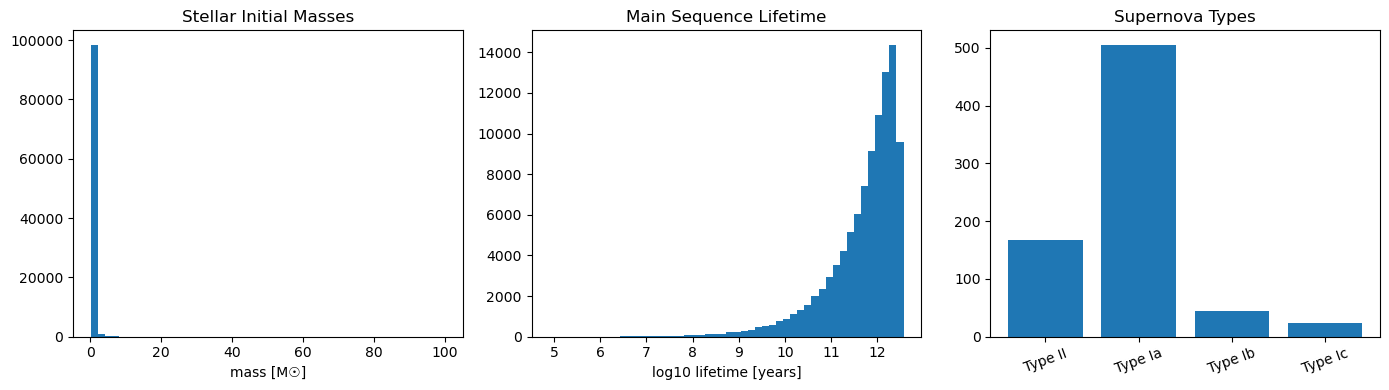

In [9]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(masses, bins=50)
plt.xlabel("mass [M☉]")
plt.title("Stellar Initial Masses")

plt.subplot(1,3,2)
plt.hist(np.log10(lifetimes), bins=50)
plt.xlabel("log10 lifetime [years]")
plt.title("Main Sequence Lifetime")

plt.subplot(1,3,3)
plt.bar(unique, counts)
plt.title("Supernova Types")
plt.xticks(rotation=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR/"single_star_population_results.png", dpi=150)
plt.show()
plt.close()

# PART 2: multiple Monte-Carlo-runs: 
### How do the supernova rate and type distribution change depending on the initial conditions of a star population?

we will now look at how changing comparitive parameters can change our output
we will vary: maximum mass when sampling masses
we will see: rare core-collapse sn will happen more often?

(other interesting parameters we did not choose: varying binary fraction, IMF-function, distribution of metallicity, ia-efficiancy)

### 0. import te necessary function to make multiple monte-carlo-runs

In [10]:
from src.mc_functions import run_single_mc, mc_statistics


### 1. Monte-Carlo
For every m_max value the simulation we established above (with N=100000) is run 100 times.

In [11]:
### THIS STEP TAKES ABOUT 4 MINUTES TO RUN ###

N = 100000
n_realizations = 100

m_max_values = [30, 50, 80, 120, 150, 200]

comparison_results = {}

for m_max in m_max_values:
    stats = mc_statistics(N=N, m_max=m_max, n_realizations=n_realizations)
    comparison_results[m_max] = stats


### 2. Results

(even though type ia supernovae occur in our sampled population, they do not appear in  
the MC statistice because binary systems are not included in this model)

In [12]:
for m_max, stats in comparison_results.items():
    print(f"\nm_max = {m_max} m_sun")
    for sn_type, values in stats.items():
        print(
            f"  {sn_type:15s} "
            f"mean={values['mean']:.1f}, "
            f"std={values['std']:.1f}, "
            f"CI68={values['ci_68']}, "
            f"CI95={values['ci_95']}"
        )



m_max = 30 m_sun
  core_collapse   mean=223.0, std=13.7, CI68=(np.float64(209.0), np.float64(235.16)), CI95=(np.float64(200.9), np.float64(248.0))
  type_ia         mean=0.0, std=0.0, CI68=(np.float64(0.0), np.float64(0.0)), CI95=(np.float64(0.0), np.float64(0.0))
  total           mean=223.0, std=13.7, CI68=(np.float64(209.0), np.float64(235.16)), CI95=(np.float64(200.9), np.float64(248.0))

m_max = 50 m_sun
  core_collapse   mean=244.8, std=15.5, CI68=(np.float64(228.84), np.float64(260.0)), CI95=(np.float64(218.0), np.float64(271.525))
  type_ia         mean=0.0, std=0.0, CI68=(np.float64(0.0), np.float64(0.0)), CI95=(np.float64(0.0), np.float64(0.0))
  total           mean=244.8, std=15.5, CI68=(np.float64(228.84), np.float64(260.0)), CI95=(np.float64(218.0), np.float64(271.525))

m_max = 80 m_sun
  core_collapse   mean=257.9, std=15.3, CI68=(np.float64(240.0), np.float64(272.0)), CI95=(np.float64(230.9), np.float64(288.04999999999995))
  type_ia         mean=0.0, std=0.0, CI68=(n

Aggregated results:

In [13]:
rows = []

for m_max, stats in comparison_results.items():
    cc = stats["core_collapse"]
    
    rows.append({
        "M_max": m_max,
        "CCSN_mean": cc["mean"],
        "CCSN_std": cc["std"],
        "CCSN_CI95_low": cc["ci_95"][0],
        "CCSN_CI95_high": cc["ci_95"][1]
    })

df_results = pd.DataFrame(rows)
df_results = df_results.sort_values("M_max").reset_index(drop=True)

df_results


,M_max,CCSN_mean,CCSN_std,CCSN_CI95_low,CCSN_CI95_high
0,30,223.03,13.717537,200.900,248.000
1,50,244.84,15.451926,218.000,271.525
2,80,257.87,15.324540,230.900,288.050
3,120,262.15,14.239208,236.000,286.050
4,150,265.78,16.048903,237.475,292.000
5,200,266.52,15.804666,236.475,295.575


### 3. Visualisation: Correlation between maximum mass and amount of core-collapses

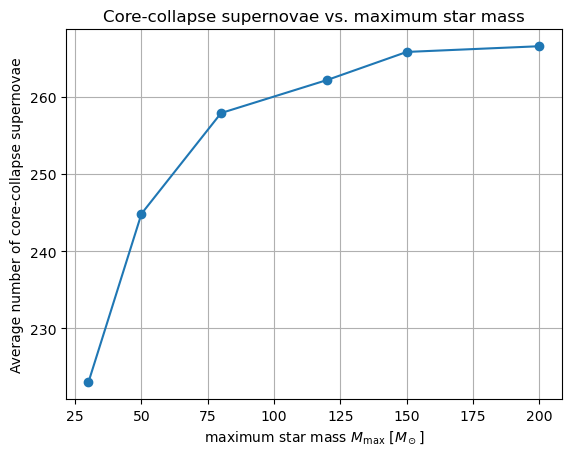

In [14]:
plt.figure()
plt.plot(
    df_results["M_max"],
    df_results["CCSN_mean"],
    marker="o"
)

plt.xlabel(r"maximum star mass $M_{\mathrm{max}}$ [$M_\odot$]")
plt.ylabel("Average number of core-collapse supernovae")
plt.title("Core-collapse supernovae vs. maximum star mass")
plt.grid(True)
plt.savefig(FIGURES_DIR/"ccsn_vs_m_max.png", dpi=150)
plt.show()
plt.close()


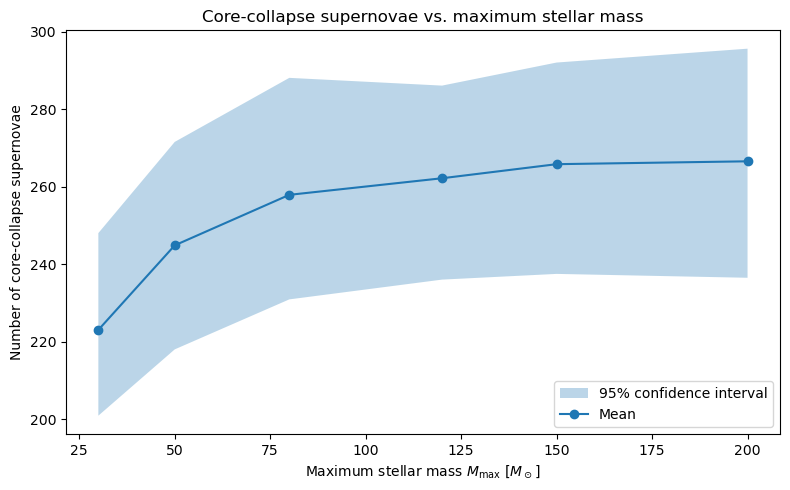

In [15]:
plt.figure(figsize=(8, 5))

plt.fill_between(
    df_results["M_max"].values,
    df_results["CCSN_CI95_low"].values,
    df_results["CCSN_CI95_high"].values,
    alpha=0.3,
    label="95% confidence interval"
)

plt.plot(
    df_results["M_max"].values,
    df_results["CCSN_mean"].values,
    marker="o",
    label="Mean"
)

plt.xlabel("Maximum stellar mass $M_{\\mathrm{max}}$ [$M_\\odot$]")
plt.ylabel("Number of core-collapse supernovae")
plt.title("Core-collapse supernovae vs. maximum stellar mass")

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR/"ccsn_confidence_interval.png", dpi=150)
plt.show()
plt.close()


### 4. Interpretation

the results show a ~linear relation






